## Rewritten Code

In [1]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Current verison of Python is", sys.version)

import os
import pathlib
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import dedalus.core as dec
from dedalus.tools import post 
import logging
logger = logging.getLogger(__name__)
plt.rcParams['text.usetex'] = True

from dedalus.core.operators import GeneralFunction
from dedalus.extras import flow_tools
import shutil
from mpi4py import MPI

Current verison of Python is 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]


In [4]:
### Simulation Parameters

Nx = 64 #64
Ny = 512 #128
Ly = 20*np.pi
Lx = 10
y0 = Ly/4

# Alpha
# alpha = 1
# f0 = 2.0
print(f"Spacing: {20*np.pi/Ny}")

Spacing: 0.1227184630308513


In [5]:
### EVP PARAMETERS 
h_g = None
u_g = None
v_g = None
eig_sel = None

kx  = None
# target_omega = 0.7

h_gs = []
u_gs = []
v_gs = []
y = None


In [6]:

def EVP_solve(k_x, target_omega, alph, f0):
    alpha = alph
    y    = d3.Coordinate('y')
    dist = d3.Distributor(y, dtype=np.complex128)
    Y    = d3.ComplexFourier(y, size=Ny, bounds=(-Ly/2, Ly/2))

    _dy   = lambda A: d3.Differentiate(A, y)
    _dx   = lambda A: (-1j*k_x)*A           
    _dt   = lambda A: ( 1j)*omega*A         
    # lift = lambda A: d3.Lift(A, Y.derivative_basis(1), -1)

    u = dist.Field(name='u', bases=Y)
    v = dist.Field(name='v', bases=Y)
    h = dist.Field(name='h', bases=Y)
    omega = dist.Field(name='omega')        

    yy = dist.local_grids(Y)[0]
    f  = dist.Field(name='f', bases=Y)
    # f['g'] = np.sin(2*np.pi*yy/Ly)
    f['g'] = f0*(np.tanh(alph*(yy-y0)) -np.tanh(alph*(yy+y0)) +1)

    problem = d3.EVP([u, v, h], eigenvalue=omega, namespace=locals())
    problem.add_equation("_dt(u) + _dx(h) - f*v = 0")
    problem.add_equation("_dt(v) + _dy(h) + f*u = 0")
    problem.add_equation("_dt(h) + _dx(u) + _dy(v) = 0")
    # problem.add_equation("v(y='left')  = 0")
    # problem.add_equation("v(y='right') = 0")

    solver = problem.build_solver()

    solver.solve_dense(solver.subproblems[0])

    order = np.argsort(solver.eigenvalues.real)
    eigs  = solver.eigenvalues[order]
    print("First few eigenvalues:", eigs[:50])

    # pick 
    tol = 1e-3
    # cand = np.where(np.abs(eigs.real - target_omega) < tol)[0]
    omega_idx = np.argmin(np.abs(eigs.real - target_omega))

    omega_idx_unsorted = np.argmin(np.abs(solver.eigenvalues.real - target_omega))
    eig_sel = eigs[omega_idx]
    cand_doublet = np.where((np.abs(eigs.real - target_omega) < tol) & (eigs.real !=eig_sel))[0]
    # omega_idx_unsorted_doublet = cand_doublet[0] if cand.size else np.argmin(np.abs(solver.eigenvalues.real - target_omega))
    # eig_doublet = eigs[omega_idx_unsorted_doublet]
    print(f"Alpha = {alph} Omega:", eig_sel.real, " Doublet: ", eigs[omega_idx-1].real)

    ### Find h for each doublet mode
    solver.set_state(omega_idx_unsorted)
    y1d = dist.local_grids(Y, scales=1)[0]
    h_g = h['g'].copy()
    u_g = u['g'].copy()
    v_g = v['g'].copy()
    
    # print(omega_idx_unsorted_doublet)
    # solver.set_state(omega_idx_unsorted_doublet)
    # h_g_doublet = h['g'].copy()

    # plot
    plt.figure(figsize=(9, 6))
    plt.plot(y1d, np.real(h_g), color = 'black', lw = 2)
    # plt.plot(y1d, np.real(h_g_doublet))

    ############### AXES, LABELS, SPINES 
    plt.tick_params('both', size = 8, width = 1.5, direction = 'in')
    plt.xlabel('$$y$$', fontsize = 25, color = 'dimgray')
    plt.ylabel('$$h$$', fontsize = 25, color = 'dimgray')


    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('dimgray')
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(f'$$\\alpha={alph}, k_x = {k_x},  \\omega = {eig_sel.real:.6f}, f_0 = {f0}$$',  fontsize = 25, color = 'dimgray')
    # axin.tick_params(axis='both', colors='dimgray') 
    ax.tick_params(axis='both', colors='dimgray') 

    # plt.savefig(f'/Users/Luitbald/CODE/Dedalus/ShallowWaterEquations/dedalus_figures/{alpha}_{Ny}res_yanai.png', dpi = 400)

    h_gs.append(np.real(h_g))
    u_gs.append(np.real(u_g))
    v_gs.append(np.real(v_g))

2025-10-13 08:54:14,014 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
First few eigenvalues: [-25.61470356-9.07461514e-19j -25.52259703-2.86287641e-17j
 -25.51476169-1.42164891e-16j -25.42268599+1.79165453e-15j
 -25.42260239+1.13172296e-15j -25.32364426+2.40272529e-15j
 -25.32269139+2.52427703e-15j -25.223738  +2.83390124e-15j
 -25.22371879+6.73827970e-15j -25.12415395+5.19680879e-17j
 -25.12381312+6.62111177e-17j -25.02425047-1.46558762e-14j
 -25.02424278-8.76263108e-15j -24.92451345-9.61984364e-15j
 -24.92434001-9.69264570e-15j -24.82461219+5.10865991e-16j
 -24.82460824+5.68031462e-15j -24.72481263-2.38480473e-15j
 -24.72470775-2.37951499e-15j -24.62491339-6.93043652e-15j
 -24.62491104-4.21684950e-15j -24.52508286-5.08043926e-15j
 -24.5250126 -5.08644020e-15j -24.42518555-4.54110841e-15j
 -24.42518402+8.41609173e-16j -24.32533789-3.61556551e-15j
 -24.32528754-3.59130387e-15j -24.22544248+8.18941054e-15j
 -24.22544142+4.460

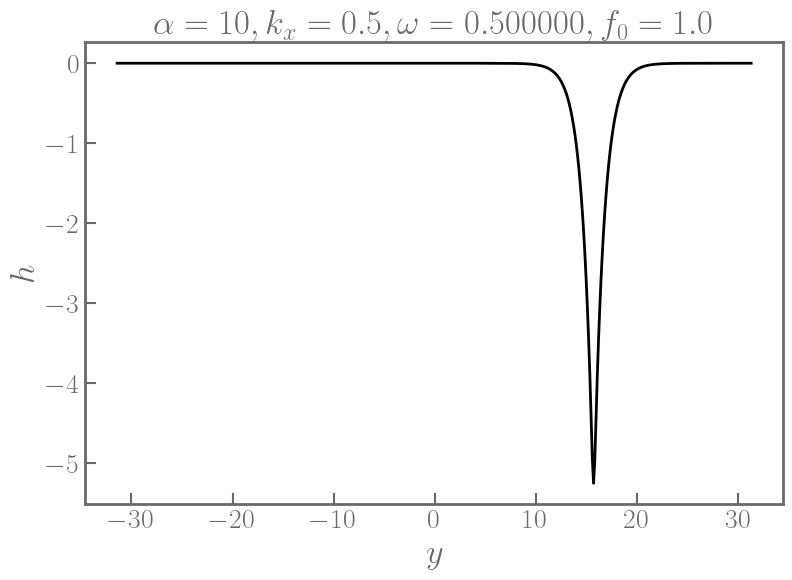

In [ ]:
f0s= [1.0, 1.0, 1.0, 1.0]
omtargets= [0.5, -0.5, 0.25, 0.25]
alphas = [10, 10]
kxs = [0.5, 0.5]
# omtargets = kxs ### omega = kx for KELVIN
for i in range(len(alphas)): 
    EVP_solve(kxs[i], omtargets[i], alphas[i], f0s[i])


### IMPORTANT: set kx: 
kx = kxs[0]
alpha = alphas[0]


In [6]:
# # plot
# plt.figure(figsize=(9, 6))
# plt.plot(np.linspace(-Ly/2, Ly/2, Ny), np.real(h_gs[0]), color = 'black', lw = 2)
# # plt.plot(y1d, np.real(h_g_doublet))

#     ############### AXES, LABELS, SPINES 
# plt.tick_params('both', size = 8, width = 1.5, direction = 'in')
# plt.xlabel('$$y$$', fontsize = 25, color = 'dimgray')
# plt.ylabel('$$h$$', fontsize = 25, color = 'dimgray')


# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     spine.set_color('dimgray')
#     # ax.spines['right'].set_visible(False)
#     # ax.spines['top'].set_visible(False)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# # plt.title(f'$$\\alpha={alph}, k_x = {k_x},  \\omega = {eig_sel.real:.6f}, f_0 = {f0}$$',  fontsize = 25, color = 'dimgray')
#     # axin.tick_params(axis='both', colors='dimgray') 
# ax.tick_params(axis='both', colors='dimgray') 

In [7]:
# h_gs[0]

In [8]:
# # plot
# plt.figure(figsize=(9, 6))
# colors = ['k', 'red', 'royalblue', 'darkorange', 'mediumvioletred']
# y_ = np.linspace(-Ly/2, Ly/2, Ny)
# for i in range(len(h_g_save)): 
#     if(i==2):
#         plt.plot(y_, -1*h_g_save[i].real, color = colors[i], lw = 2) 
#         continue
#     plt.plot(y_, h_g_save[i].real, color = colors[i], lw = 2)

#     # plt.plot(y1d, np.real(h_g_doublet))

# ############### AXES, LABELS, SPINES 
# plt.tick_params('both', size = 8, width = 1.5, direction = 'in')
# plt.xlabel('$$y$$', fontsize = 25, color = 'dimgray')
# plt.ylabel('$$h$$', fontsize = 25, color = 'dimgray')


# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     spine.set_color('dimgray')
#     # ax.spines['right'].set_visible(False)
#     # ax.spines['top'].set_visible(False)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.title(f'$$\\alpha={alpha}, k_x = {kx}$$',  fontsize = 25, color = 'dimgray')
# plt.text(-5, 1.4,f'$$f_0 = 1.0$$', color = 'k', fontsize =20)
# plt.text(-5, 1.2,f'$$f_0 = 1.2$$', color = 'red', fontsize =20)
# plt.text(-5, 1.0,f'$$f_0 = 1.5$$', color = 'royalblue', fontsize =20)
# plt.text(-5, 0.8,f'$$f_0 = 2.0$$', color = 'darkorange', fontsize =20)

# # axin.tick_params(axis='both', colors='dimgray') 
# ax.tick_params(axis='both', colors='dimgray') 

# plt.savefig(f'/Users/Luitbald/CODE/Dedalus/ShallowWaterEquations/dedalus_figures/{alpha}_f0_yanai.png', dpi = 400)

In [9]:
# # plot
# plt.figure(figsize=(9, 6))
# # plt.plot(y1d, h_g_save[0], lw = 2)
# plt.plot(y1d, h_g_save[1], lw = 2)

#     # plt.plot(y1d, np.real(h_g_doublet))

# ############### AXES, LABELS, SPINES 
# plt.tick_params('both', size = 8, width = 1.5, direction = 'in')
# plt.xlabel('$$y$$', fontsize = 25, color = 'dimgray')
# plt.ylabel('$$h$$', fontsize = 25, color = 'dimgray')


# ax = plt.gca()
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     spine.set_color('dimgray')
#     # ax.spines['right'].set_visible(False)
#     # ax.spines['top'].set_visible(False)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# # plt.title(f'$$\\alpha={alpha}, k_x = {kx},  \\omega = {eig_sel.real:.6f}, f_0 = {f0}$$',  fontsize = 25, color = 'dimgray')
#     # axin.tick_params(axis='both', colors='dimgray') 
# ax.tick_params(axis='both', colors='dimgray') 

# # plt.savefig(f'/Users/Luitbald/CODE/Dedalus/ShallowWaterEquations/dedalus_figures/{alpha}_{Ny}res_yanai.png', dpi = 400)

In [8]:
#### SET IVP PARAMETERS

# ### PICK CORRECT ONE
# eigenmode_h =(h_gs[0] + h_gs[1])
# eigenmode_u =( u_gs[0] + h_gs[1])
# eigenmode_v =( v_gs[0] + h_gs[1])
eigenmode_h = h_gs[0] 
eigenmode_u = u_gs[0] 
eigenmode_v = v_gs[0] 



In [9]:
coords = d3.CartesianCoordinates('x','y')
dist = d3.Distributor(coords, dtype=np.float64)

x_basis = d3.RealFourier(coords['x'], Nx, bounds=[-Lx/2, Lx/2], dealias=1.0)
y_basis = d3.RealFourier(coords['y'], Ny, bounds=[-Ly/2, Ly/2], dealias = 1.0)
# lift_basis = y_basis.derivative_basis(1)

# tau_basis = y_basis.derivative_basis(1)
# #
u = dist.Field(name='u', bases=[x_basis, y_basis])
v = dist.Field(name='v', bases=[x_basis, y_basis])
h = dist.Field(name='h', bases=[x_basis, y_basis])
f = dist.Field(name='f', bases=[y_basis])

g_op = lambda A: A*f

# p1 = dist.Field(bases = tau_basis)
# p2 = dist.Field(bases = tau_basis)
# p1['c'][-1] = 1
# p2['c'][-1] = 1

# tau_1 = dist.Field(name = 'tau_1', bases = x_basis)
# tau_2 = dist.Field(name = 'tau_2', bases = x_basis)

dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
# lift = lambda A: d3.Lift(A, lift_basis, -1)

x, y = dist.local_grids(x_basis, y_basis)
f['g'] = np.tanh(alpha*(y - y0)) - np.tanh(alpha*(y + y0)) + 1.0 #TANH CORIOLIS PARAMETER
# f['g'] =np.sin(2*np.pi*y/Ly) #sin coriolis parameter 

# Initial conditions
u['g'] = eigenmode_u.real*np.cos(kx*x)
v['g'] = eigenmode_v.real*np.cos(kx*x)
h['g'] = eigenmode_h.real*np.cos(kx*x)


# IVP without user taus
problem = d3.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + dx(h) - f*v = 0")
problem.add_equation("dt(v) + dy(h) + f*u  = 0")
problem.add_equation("dt(h) + dx(u) + dy(v) = 0")

# BCs in y (Chebyshev direction)
# problem.add_equation("v(y='left') = 0")
# problem.add_equation("v(y='right') = 0")

solver = problem.build_solver('RK222')  

2025-10-13 08:55:36,582 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 6s, Rate: 4.8e+00/s
2025-10-13 08:55:37,107 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 1s, Remaining: 5s, Rate: 5.4e+00/s
2025-10-13 08:55:37,798 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 1s, Remaining: 4s, Rate: 5.6e+00/s
2025-10-13 08:55:38,486 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 2s, Remaining: 4s, Rate: 5.7e+00/s
2025-10-13 08:55:39,168 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 3s, Remaining: 3s, Rate: 5.7e+00/s
2025-10-13 08:55:39,842 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 5.8e+00/s
2025-10-13 08:55:40,515 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 4s, Remaining: 1s, Rate: 5.8e+00/s
2025-10-13 08:55:41,184 subsystems 0/1 INFO :: Building subproblem matric

In [ ]:
solver.stop_sim_time = 10
solver.stop_wall_time = np.inf
solver.stop_iteration = 1000

vel = d3.VectorField(dist,coordsys =coords, bases=(x_basis, y_basis), name='vel')


init_dt = 0.001
CFL = flow_tools.CFL(solver, initial_dt=init_dt, cadence=10, safety=0.3, max_change=1.5)
CFL.add_velocity(vel)

u_max= []
u_list = []
h_list = []
t_list = []

logger.info('Starting loop')
start_time = time.time()
dt = 0.005
while solver.proceed:
    solver.step(dt)

    vel['g'][0] = u['g'].real
    vel['g'][1] = v['g'].real

    dt = CFL.compute_timestep()
    t_list.append(solver.sim_time)
    u_list.append(np.copy(u['g']))
    h_list.append(np.copy(h['g']))
    
    if solver.iteration % 10 == 0:
        print('Completed iteration {}, time {}, dt {}'.format(solver.iteration, t_list[-1], dt))

end_time = time.time()

# np.set_array(np.ravel(u['g'].T))
# display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))

logger.info('Iterations: %i' %solver.iteration)

2025-10-13 08:55:41,859 __main__ 0/1 INFO :: Starting loop
Completed iteration 10, time 0.014000000000000005, dt 0.001
Completed iteration 20, time 0.02850000000000002, dt 0.0015
Completed iteration 30, time 0.05025000000000004, dt 0.0022500000000000003
Completed iteration 40, time 0.08287500000000006, dt 0.0033750000000000004
Completed iteration 50, time 0.13181250000000005, dt 0.005062500000000001
Completed iteration 60, time 0.20521875000000014, dt 0.0075937500000000015
Completed iteration 70, time 0.2930940142341855, dt 0.008920168248242807
Completed iteration 80, time 0.3822649161935229, dt 0.008916748190121618
Completed iteration 90, time 0.4714989052594015, dt 0.008924137875084122
Completed iteration 100, time 0.5606679294304088, dt 0.00891609847732482
Completed iteration 110, time 0.6498913673821313, dt 0.008923037719377473
Completed iteration 120, time 0.7390687095974646, dt 0.008917144943995068
Completed iteration 130, time 0.8282584486433973, dt 0.008919177122437554
Complete

In [13]:
# h_list = np.real(h_list)
# u_list = np.real(u_list)
# # v_list = np.real(v_list)

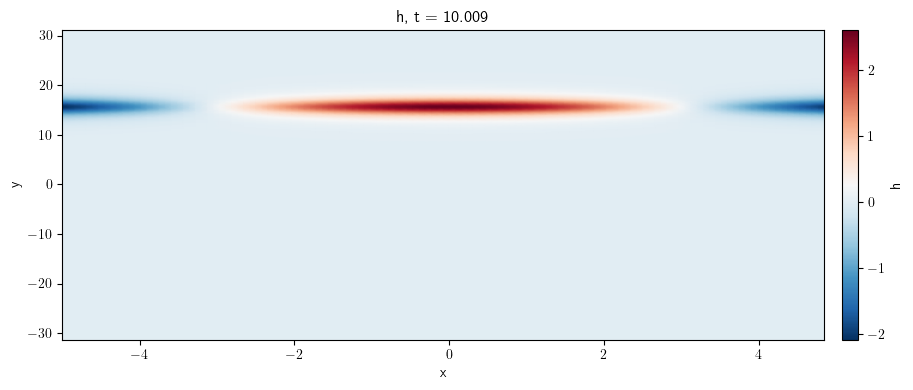

In [ ]:
# dealiased grids to match h['g']
xd, yd = dist.local_grids(x_basis, y_basis, scales=(1, 1))  # or scales=1.5
Xm, Ym = np.meshgrid(xd, yd, indexing='xy')  # shapes (Ny_d, Nx_d)

H = h_list[-1]                      # shape (Nx_d, Ny_d) == (105, 182)
fig, ax = plt.subplots(figsize=(10,4))
pc = ax.pcolormesh(Xm, Ym, H.T, shading='gouraud', cmap='RdBu_r')  # transpose -> (Ny_d, Nx_d)
fig.colorbar(pc, ax=ax, pad=0.02).set_label('h')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title(f'h, t = {t_list[-1]:.3f}')
plt.tight_layout(); plt.show()


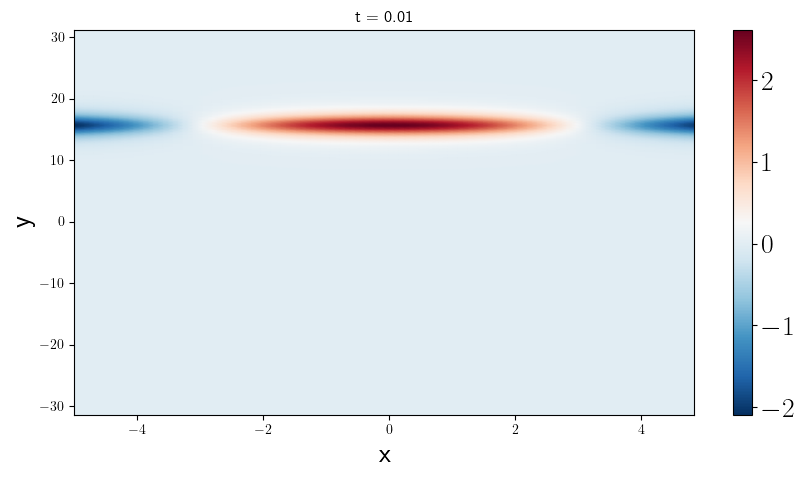

In [ ]:
from matplotlib import animation 

xm, ym = np.meshgrid(x,y)

fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, np.array(h_list[0]).T, cmap='RdBu_r', shading='gouraud')
axis.set_title('t = {:6.2f}'.format(t_list[0]))
axis.set_xlabel('x',size=20)
axis.set_ylabel('y',size=20)
cbar = fig.colorbar(p,ax=axis)
cbar.ax.tick_params(labelsize=20)


u_all = np.array(u_list)
h_all = np.array(h_list)
p.set_clim(np.min(h_all[:]), np.max(h_all[:]))
plt.show()
# p.set_clim(-0.02,0.02)

def init():
    p.set_array(np.ravel(np.array(h_list[0]).T))
    return p

def animate(i): 

    p.set_array(np.ravel(np.array(h_list[(i+1)*10]).T))
    axis.set_title('t = {:6.2f}'.format(t_list[(i+1)*10]))

    return p


ani = animation.FuncAnimation(fig, animate, frames=int(len(t_list)/10-1))
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='L'), bitrate=2000)


In [ ]:
import os
from datetime import datetime

ani.save(f'/Users/luitbald/CODE/Dedalus/ShallowWaterEquations/movies/{datetime.now().strftime("%y-%m-%d %H:%M")}_kx{kx}_alpha{alpha}.mp4', writer=writer)
plt.show()

2025-10-13 08:49:42,067 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-13 08:49:42,068 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -framerate 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -b 2000k -metadata artist=L -y '/Users/luitbald/CODE/Dedalus/ShallowWaterEquations/movies/25-10-13 08:49_kx0.5_alpha1.0.mp4'
